In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
# 1. Wczytanie datasetu
full_df = pd.read_csv('../dataset/full_dataset.csv')
full_df.head()

,sample_id,frame,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,landmark_21_x,landmark_21_y,landmark_21_z
0,1,0,A,0.345417,0.648431,-1.125724e-07,0.363545,0.620765,-0.010274,0.367171,...,-0.003865,0.321722,0.551512,-0.008457,0.326903,0.565844,-0.005724,0.329682,0.577548,-0.001789
1,1,1,A,0.366266,0.597102,-9.622672e-08,0.391580,0.578109,-0.012907,0.406190,...,0.000685,0.356418,0.497935,-0.004451,0.361665,0.515749,-0.001988,0.363353,0.523833,0.002337
2,1,2,A,0.400966,0.572690,-1.089629e-07,0.424555,0.552354,-0.004017,0.439723,...,-0.004296,0.383425,0.481909,-0.009304,0.389207,0.502081,-0.005430,0.391897,0.513775,-0.000924
3,1,3,A,0.418257,0.573744,-1.190043e-07,0.441344,0.563031,-0.007786,0.460869,...,-0.002903,0.402536,0.489501,-0.009669,0.406139,0.510639,-0.006567,0.409394,0.523706,-0.001918
4,1,4,A,0.431913,0.582072,-1.241054e-07,0.453692,0.577044,-0.009167,0.474907,...,-0.004793,0.417201,0.501486,-0.012369,0.419653,0.524298,-0.008715,0.422120,0.535854,-0.003439


In [5]:
# 2. Wstępne przetwarzanie
df = full_df.drop(columns=['user_id'], errors='ignore')
df['label'] = df['label'].astype('category')

In [6]:
# 3. Podział na sekwencje (X, y)
SEQUENCE_LENGTH = 30
FEATURE_DIM = 63  # 21 punktów * 3 współrzędne


def extract_sequences(df):
    sequences, labels = [], []
    for sample_id, group in df.groupby('sample_id'):
        group = group.sort_values('frame').reset_index(drop=True)
        label = group.loc[0, 'label']
        data = group.drop(columns=['sample_id', 'frame', 'label'], errors='ignore')

        for start in range(0, len(data) - SEQUENCE_LENGTH + 1):
            segment = data.iloc[start:start + SEQUENCE_LENGTH].values
            sequences.append(segment)
            labels.append(label)

    return np.array(sequences), np.array(labels)


X_all, y_all = extract_sequences(df)
del df, full_df

In [7]:
# 4. Normalizacja względem nadgarstka pierwszej klatki

def normalize_wrist(sequence):
    sequence = sequence.copy()
    wrist_origin = sequence[0].reshape(21, 3)[0]
    return np.array([(frame.reshape(21, 3) - wrist_origin).flatten() for frame in sequence])


X_all = np.array([normalize_wrist(seq) for seq in X_all])


In [8]:
# 5. Kodowanie etykiet
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)
y_all_cat = to_categorical(y_all_enc)
num_classes = y_all_cat.shape[1]

In [14]:
# 6. Podział na zbiory
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_cat, test_size=0.15, stratify=y_all_enc,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=np.argmax(y_train, axis=1),
                                                  random_state=42)

In [16]:
def augment(sequence, augment_config):
    seq = tf.identity(sequence)

    # Flip co trzeciego kanału (np. X w XYZ), zakładając że FEATURE_DIM = 3n
    if augment_config.get('flip', False):
        # Maska dla osi X (co trzecia cecha, zaczynając od 0)
        x_indices = tf.range(tf.shape(seq)[-1]) % 3 == 0
        flip_mask = tf.cast(x_indices, seq.dtype)
        seq = seq * (1 - 2 * flip_mask)  # mnożenie przez -1 dla osi X

    # Szum Gaussowski
    if augment_config.get('gaussian_noise', False):
        noise = tf.random.normal(tf.shape(seq), mean=0.0, stddev=0.01, dtype=tf.float64)
        seq += noise

    # Szum speckle (proporcjonalny do wartości oryginalnych)
    if augment_config.get('speckle_noise', False):
        noise = tf.random.normal(tf.shape(seq), mean=0.0, stddev=0.01, dtype=tf.float64)
        noise = tf.sqrt(tf.abs(seq)) * noise
        noise = tf.where(
            noise < 0.01,
            tf.zeros_like(noise),
            noise
        )
        seq += seq * noise

    # Szum typu salt & pepper
    if augment_config.get('salt_pepper', False):
        prob = 0.01
        rnd = tf.random.uniform(tf.shape(seq))
        seq = tf.where(rnd < prob / 2, tf.zeros_like(seq), seq)
        seq = tf.where(rnd > 1 - prob / 2, tf.ones_like(seq), seq)

    return seq


In [17]:
# 8. Generator danych z augmentacją
def create_tf_dataset(X, y, batch_size=64, shuffle=True, augment_enabled=False, augment_config=None):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    def preprocess(x, y):
        if augment_enabled:
            x = augment(x, augment_config)
        return x, y

    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [21]:
# 9. Przygotowanie zbiorów
train_ds = create_tf_dataset(X_train, y_train, augment_enabled=True, augment_config={
    'flip': True,
    'gaussian_noise': True,
    'speckle_noise': False,
    'salt_pepper': False
})
val_ds = create_tf_dataset(X_val, y_val, shuffle=False)
test_ds = create_tf_dataset(X_test, y_test, shuffle=False)

In [22]:
# 10. Definicja modelu BiLSTM

from tensorflow.keras.layers import Layer, Input, LSTM, Bidirectional, Dense, Dropout, Multiply, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def create_bilstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Mechanizm Attention – poprawiona wersja
    attention_weights = Dense(1, activation='tanh')(x)
    attention_weights = Lambda(lambda z: K.softmax(z, axis=1))(attention_weights)
    context_vector = Multiply()([x, attention_weights])
    context_vector = Lambda(lambda z: K.sum(z, axis=1))(context_vector)

    x = Dense(128, activation='relu')(context_vector)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [23]:
# 11. Definicja modelu 1DCNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def create_1dcnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [24]:
from keras.src.callbacks import EarlyStopping

# 12. Trenowanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# BiLSTM z Attention
bilstm_model = create_bilstm_attention_model((30, 63), num_classes)
bilstm_model.summary()

history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 63)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 30, 128)   │     65,536 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 30, 128)   │     98,816 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 1)     │        129 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 30, 1)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 30, 128)   │          0 │ bidirectional_3[… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 36)        │      4,644 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,637 (725.14 KB)

 Trainable params: 185,637 (725.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.2590 - loss: 2.5148 - val_accuracy: 0.7185 - val_loss: 0.7443
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.7170 - loss: 0.7454 - val_accuracy: 0.8584 - val_loss: 0.3351
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.8489 - loss: 0.4305 - val_accuracy: 0.9117 - val_loss: 0.2438
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.8909 - loss: 0.3295 - val_accuracy: 0.9464 - val_loss: 0.1597
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9129 - loss: 0.2629 - val_accuracy: 0.9432 - val_loss: 0.1550
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9382 - loss: 0.1905 - val_accuracy: 0.9502 - val_loss: 0.1495
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9355 - loss: 0.2005 - val_accuracy: 0.9632 - val_loss: 0.1085
Epoch 8/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9407 - loss: 0

In [25]:

# CNN 1D
cnn_model = create_1dcnn_model((30, 63), num_classes)
cnn_model.summary()

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

/home/magda/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │        12,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,940 (546.64 KB)

 Trainable params: 139,940 (546.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2447 - loss: 2.6493 - val_accuracy: 0.8233 - val_loss: 0.5378
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7607 - loss: 0.6605 - val_accuracy: 0.9250 - val_loss: 0.2504
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8726 - loss: 0.3597 - val_accuracy: 0.9681 - val_loss: 0.1434
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9177 - loss: 0.2491 - val_accuracy: 0.9646 - val_loss: 0.1201
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9339 - loss: 0.2027 - val_accuracy: 0.9821 - val_loss: 0.0758
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9563 - loss: 0.1425 - val_accuracy: 0.9723 - val_loss: 0.0925
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9552 - loss: 0.1438 - val_accuracy: 0.9758 - val_loss: 0.0760
Epoch 8/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9685 - loss: 0.1088 - val_accu

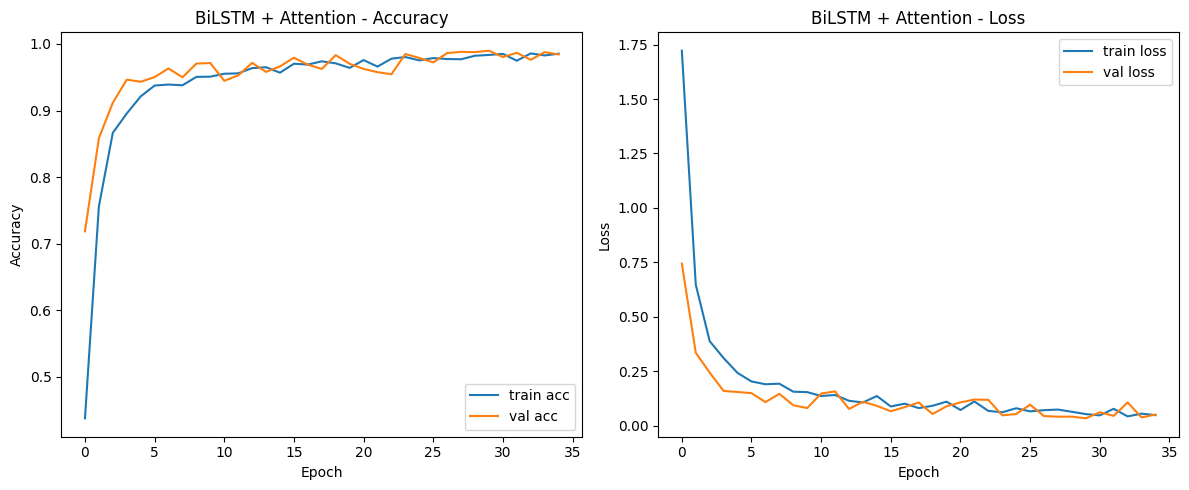

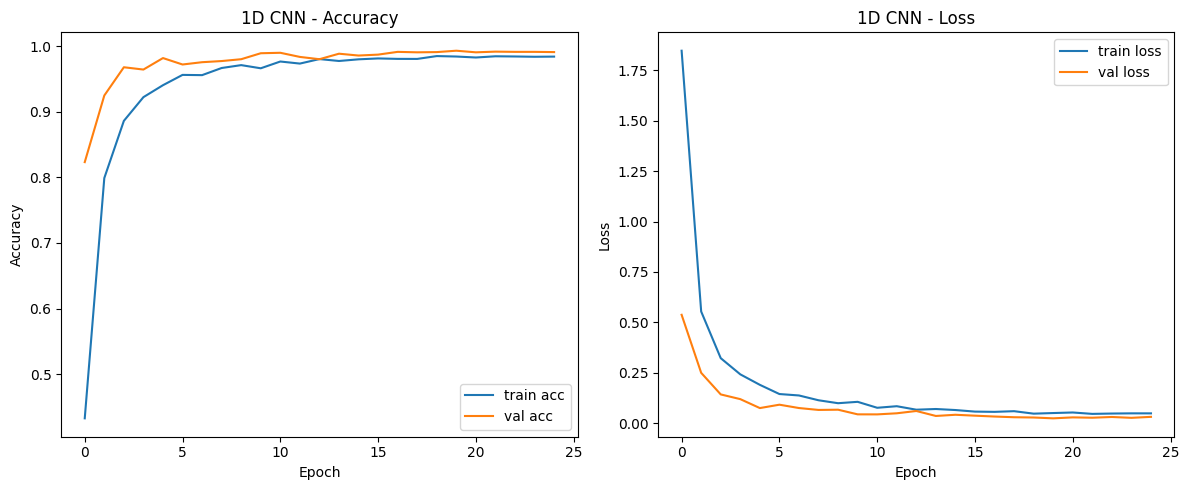

In [26]:
# Ewaluacja

import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_bilstm, "BiLSTM + Attention")
plot_history(history_cnn, "1D CNN")


In [27]:
# Ocena na zbiorze testowym
test_loss_bilstm, test_acc_bilstm = bilstm_model.evaluate(X_test, y_test, verbose=0)
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"BiLSTM + Attention — Accuracy: {test_acc_bilstm:.4f}, Loss: {test_loss_bilstm:.4f}")
print(f"1D CNN           — Accuracy: {test_acc_cnn:.4f}, Loss: {test_loss_cnn:.4f}")


BiLSTM + Attention — Accuracy: 0.9863, Loss: 0.0540
1D CNN           — Accuracy: 0.9928, Loss: 0.0301


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


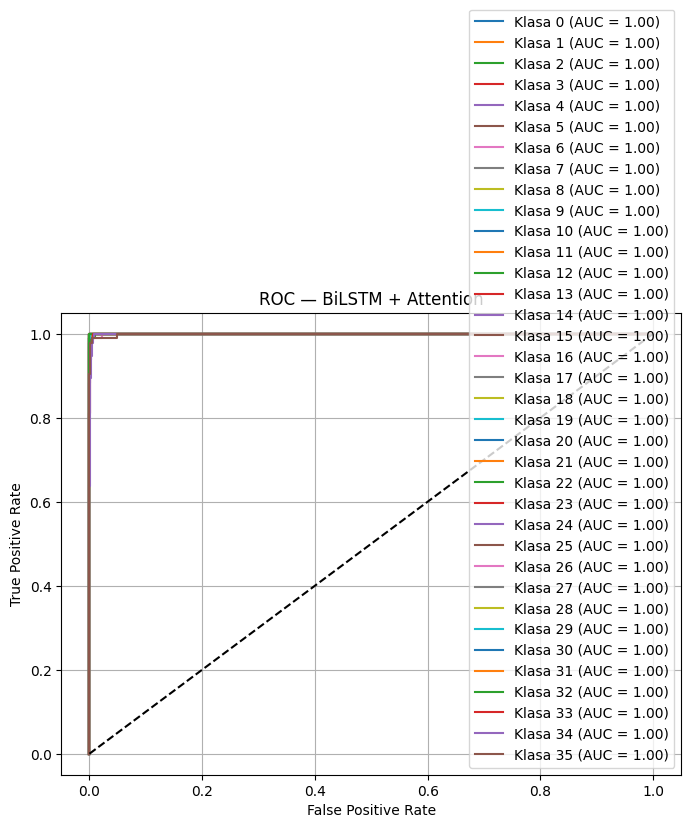

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


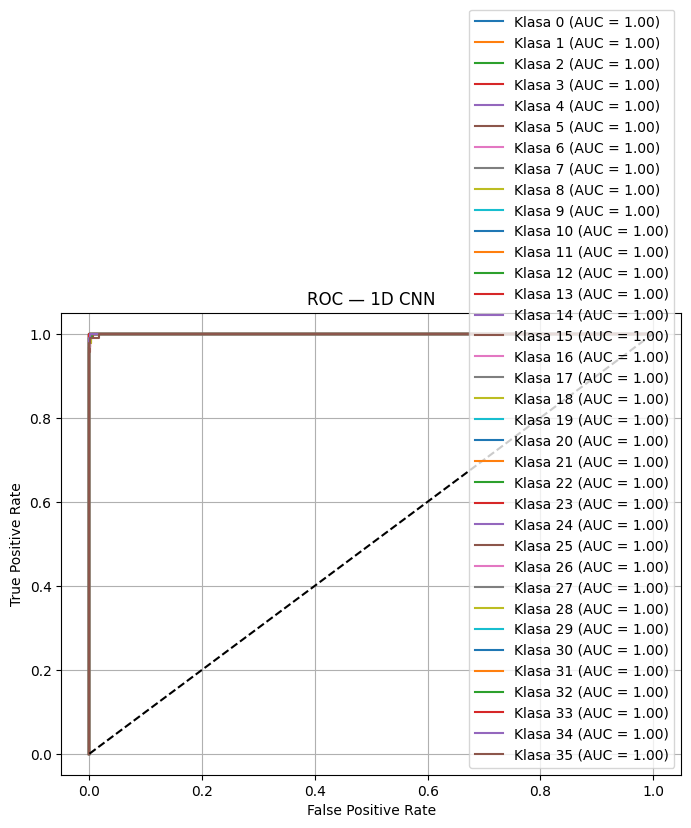

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

def plot_multiclass_roc(model, X, y_true_cat, model_name):
    y_score = model.predict(X)
    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = y_true_cat.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_cat[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Klasa {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC — {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_multiclass_roc(bilstm_model, X_test, y_test, "BiLSTM + Attention")
plot_multiclass_roc(cnn_model, X_test, y_test, "1D CNN")


In [34]:
import os
from datetime import datetime
import json

# Ustal dzisiejszą datę
today_str = datetime.now().strftime("%Y-%m-%d")

# Ścieżka zapisu modeli
save_dir = f"../model/{today_str}"
os.makedirs(save_dir, exist_ok=True)

# Ścieżki plików
bilstm_path = os.path.join(save_dir, "bilstm_attention_model.keras")
cnn_path = os.path.join(save_dir, "cnn_1d_model.keras")
labels_path = os.path.join(save_dir, "labels.txt")

# Zapis modeli
bilstm_model.save(bilstm_path)
cnn_model.save(cnn_path)

with open('../model/2025-07-14/labels.txt', 'w') as f:
    for label in le.classes_:
        f.write(label + '\n')

print(f"Modele i etykiety zapisano w folderze: {save_dir}")


Modele i etykiety zapisano w folderze: ../model/2025-07-14
